In [2]:
# Imports
from IPython.display import Image
from pgmpy.utils import get_example_model
import pprint


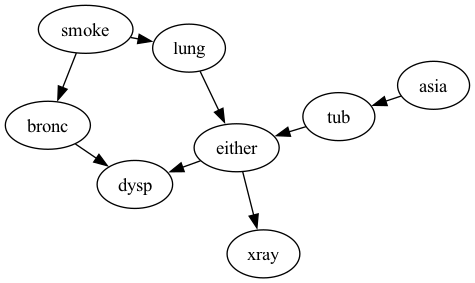

In [4]:
asia_model = get_example_model('asia')

viz =asia_model.to_graphviz()
viz.draw('asia.png', prog='neato')
Image('asia.png')

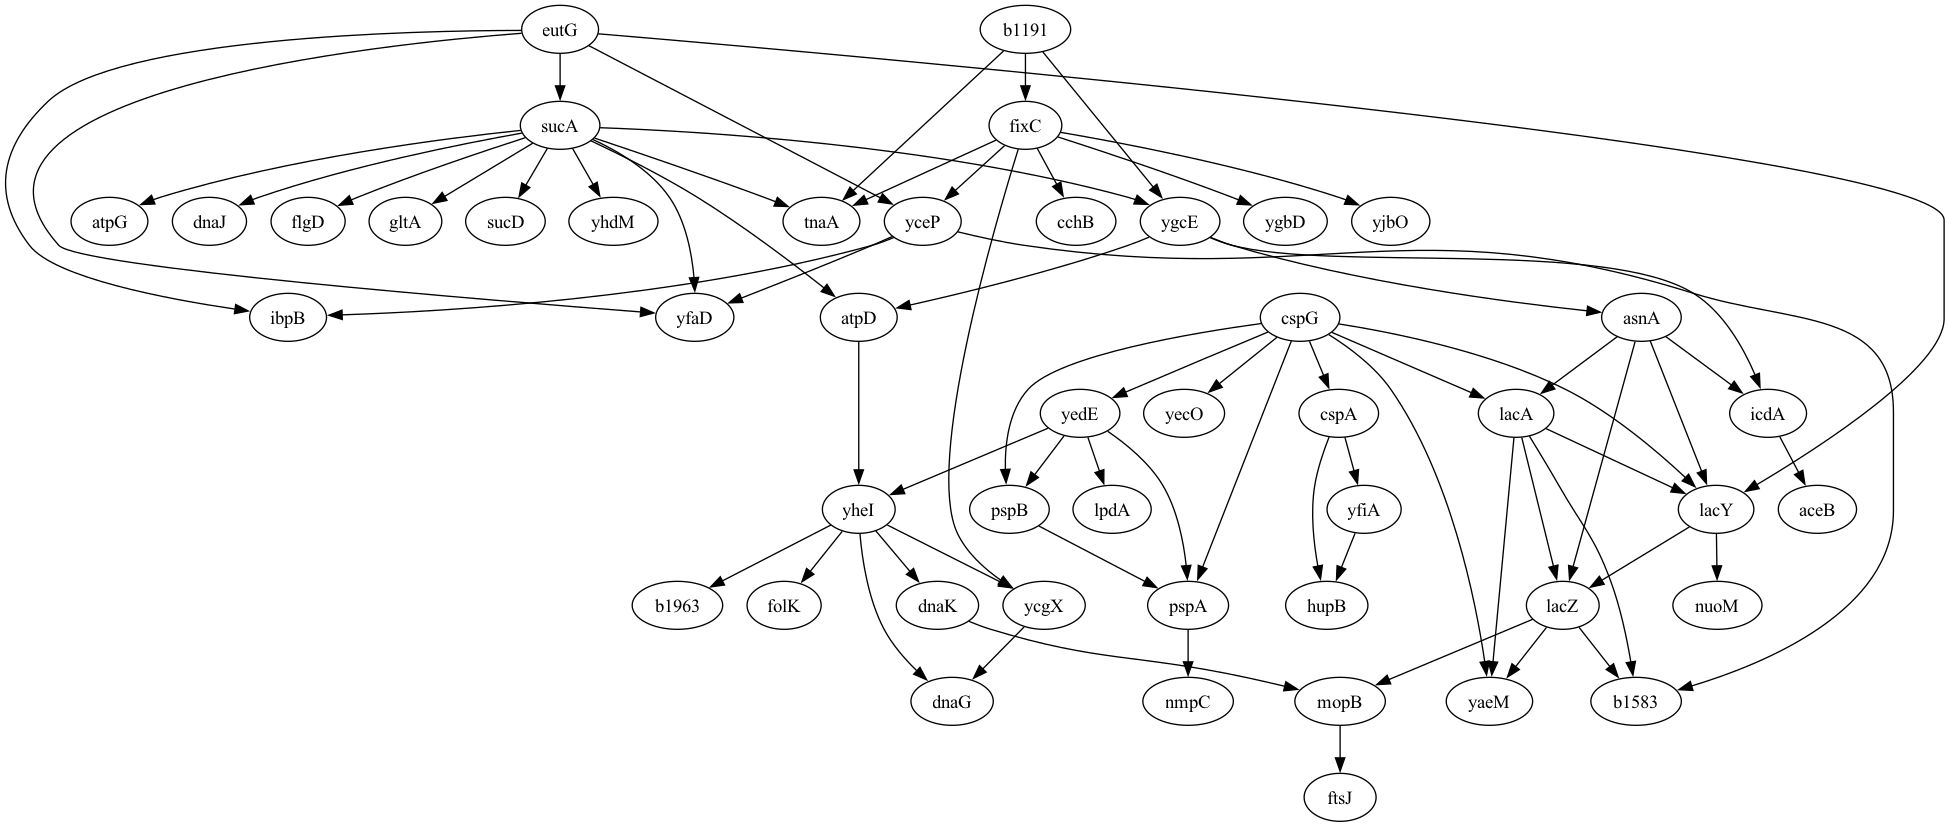

In [5]:
ecoli_model = get_example_model('ecoli70')
# Load the model
ecoli_model = get_example_model('ecoli70')

# Visualize the network
viz = ecoli_model.to_graphviz()
viz.draw('ecoli.png', prog='dot')
Image('ecoli.png')

In [9]:
model = get_example_model("sachs")

# Convert model into pygraphviz object
model_graphviz = model.to_graphviz()

# Plot the model.
model_graphviz.draw("sachs.png", prog="dot")

# Other file formats can also be specified.
model_graphviz.draw("sachs.pdf", prog="dot")
model_graphviz.draw("sachs.svg", prog="dot")

### Sensitivity analysis

Another way: Shannon mutual information to assess the ability of variables influening the costs

Model Nodes: ['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']

Model Edges: [('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')]

Available CPDs:
asia: (2,)
bronc: (2, 2)
dysp: (2, 2, 2)
either: (2, 2, 2)
lung: (2, 2)
smoke: (2,)
tub: (2, 2)
xray: (2, 2)


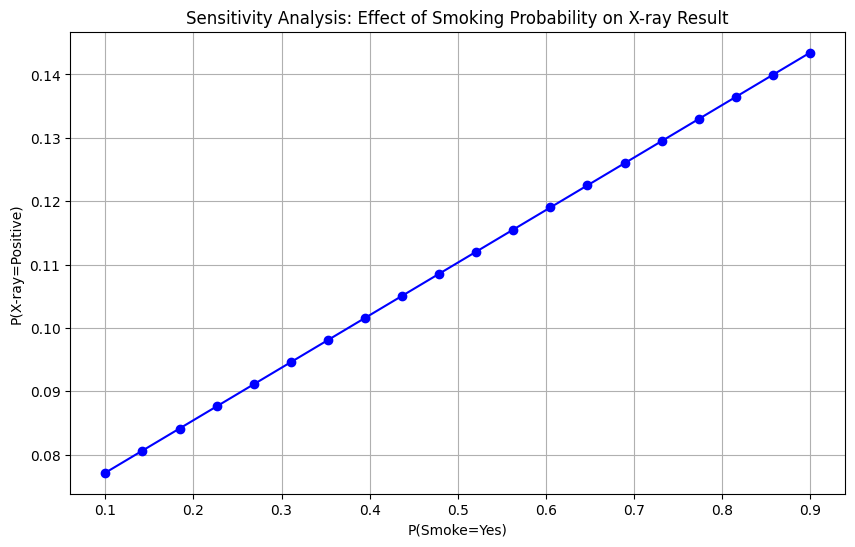


Sensitivity Statistics:
Maximum effect: 0.0663
Mean probability: 0.1103
Standard deviation: 0.0201


In [13]:
# First, let's examine the model structure
print("Model Nodes:", asia_model.nodes())
print("\nModel Edges:", asia_model.edges())
print("\nAvailable CPDs:")
for cpd in asia_model.get_cpds():
    print(f"{cpd.variable}: {cpd.values.shape}")

# Modified sensitivity analysis
def sensitivity_analysis(model, query_var, evidence_var, n_points=20):
    """
    Perform sensitivity analysis by varying CPT values and observing changes in query probability
    """
    # Verify nodes exist in model
    if query_var not in model.nodes() or evidence_var not in model.nodes():
        raise ValueError(f"Query var '{query_var}' or evidence var '{evidence_var}' not in model nodes: {model.nodes()}")
    
    inference = VariableElimination(model)
    cpd = model.get_cpds(evidence_var)
    original_values = cpd.values.copy()
    results = []
    variations = np.linspace(0.1, 0.9, n_points)
    
    for p in variations:
        # Modify CPT while maintaining sum = 1
        new_values = np.array([p, 1-p])
        if len(cpd.values.shape) > 1:
            # Handle CPTs with multiple parent configurations
            new_values = np.tile(new_values.reshape(-1, 1), 
                               (1, cpd.values.shape[1]))
        cpd.values = new_values
        model.add_cpds(cpd)
        
        # Query the probability
        result = inference.query([query_var])
        results.append(result.values[0])
    
    # Reset to original values
    cpd.values = original_values
    model.add_cpds(cpd)
    
    return variations, results

# Perform sensitivity analysis
variations, probabilities = sensitivity_analysis(
    asia_model, 
    query_var='xray',
    evidence_var='smoke',
    n_points=20
)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(variations, probabilities, 'b-', marker='o')
plt.xlabel('P(Smoke=Yes)')
plt.ylabel('P(X-ray=Positive)')
plt.title('Sensitivity Analysis: Effect of Smoking Probability on X-ray Result')
plt.grid(True)
plt.show()

# Print key statistics
print("\nSensitivity Statistics:")
print(f"Maximum effect: {max(probabilities) - min(probabilities):.4f}")
print(f"Mean probability: {np.mean(probabilities):.4f}")
print(f"Standard deviation: {np.std(probabilities):.4f}")

In [1]:
# Statistical modeling
import numpy as np
import scipy.stats as stats

# Generate data (e.g., heights in cm)
data = np.random.normal(loc=170, scale=10, size=100)

# Fit using MLE
mu_hat = np.mean(data)
sigma_hat = np.std(data, ddof=1)

print(f"Estimated mean = {mu_hat:.2f}")
print(f"Estimated std = {sigma_hat:.2f}")


Estimated mean = 170.97
Estimated std = 10.10


In [2]:
# Bayesian modeling
import pymc as pm
import arviz as az

data = np.random.normal(170, 10, 100)

with pm.Model() as bayesian_model:
    mu = pm.Normal("mu", mu=0, sigma=50)          # prior for mean
    sigma = pm.HalfNormal("sigma", sigma=10)      # prior for std
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)  # likelihood

    trace = pm.sample(1000, tune=1000, chains=2)

az.summary(trace, var_names=["mu", "sigma"])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,169.826,1.041,167.966,171.924,0.023,0.024,2040.0,1094.0,1.0
sigma,10.372,0.736,8.999,11.741,0.016,0.017,2110.0,1532.0,1.0


In [4]:
groups = ["men", "women"]
group_idx = np.repeat([0, 1], 50)
data = np.concatenate([
    np.random.normal(175, 8, 50),  # men
    np.random.normal(165, 6, 50)   # women
])

with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_pop = pm.Normal("mu_pop", mu=170, sigma=20)
    sigma_pop = pm.HalfNormal("sigma_pop", sigma=10)
    
    # Group-level parameters
    mu_group = pm.Normal("mu_group", mu=mu_pop, sigma=sigma_pop, shape=2)
    sigma_group = pm.HalfNormal("sigma_group", sigma=10)
    
    # Likelihood
    y = pm.Normal("y", mu=mu_group[group_idx], sigma=sigma_group, observed=data)
    
    trace_h = pm.sample(1500, tune=1000, chains=2)

az.summary(trace_h, var_names=["mu_pop", "mu_group"])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_pop, sigma_pop, mu_group, sigma_group]


Output()

Sampling 2 chains for 1_000 tune and 1_500 draw iterations (2_000 + 3_000 draws total) took 1 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_pop,169.803,6.170,157.954,181.559,0.129,0.146,2304.0,1852.0,1.0
mu_group[0],175.205,1.127,173.168,177.316,0.020,0.021,3056.0,1976.0,1.0
mu_group[1],164.647,1.054,162.769,166.702,0.019,0.020,3055.0,1920.0,1.0
